In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import colorcet as cc
import re
import ray
import os
import random

from functools import partial
from sklearn.decomposition import PCA
from norm import cut_norm,interpolate_and_sample,normalizeDf
from sklearn.preprocessing import StandardScaler, LabelEncoder
from torch.nn import functional as F
from ray import train, tune
from ray.train import Checkpoint
from ray.tune.schedulers import ASHAScheduler



def readsheet(sheetname,excel_file_path):
    data = pd.read_excel(excel_file_path,sheet_name=sheetname)
    #csv_file_path='data_sheetname'
    #data.to_csv(csv_file_path, index=False)
    columns_to_remove = ['Temp. [°C]']
    data.drop(columns=columns_to_remove, inplace=True)
    return data

2024-06-17 12:36:03,661	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-06-17 12:36:08,341	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


<script>
const css = `
body {
    background-color: #1E1E1E; /* Dark Modern theme background color */
    color: #D4D4D4; /* Light gray text color */
    font-family: Arial, sans-serif; /* Readable font */
}

.json-output {
    background-color: #252526; /* Slightly lighter than body background */
    color: #D4D4D4; /* Light gray text color */
    font-family: 'Courier New', Courier, monospace; /* Monospaced font for JSON */
    padding: 10px;
    border-radius: 5px;
    border: 1px solid #3C3C3C; /* Border to distinguish JSON block */
}

pre.json-output {
    overflow: auto;
    white-space: pre-wrap; /* Wrap long lines */
    word-wrap: break-word; /* Break long words */
}
`;

const style = document.createElement('style');
style.innerHTML = css;
document.head.appendChild(style);
</script>


In [2]:
#SUM ALL THE DATA
excel_file_path = 'WT_in_LB_data_Omar_s1.XLSX'
lsheetnames = ['P0002','P0005','P0008','P0012','P0030']
numbers=[0,1,2,3,4]
excel_file_path2 = 'different_conditions_data_Omar_s2.XLSX'
lsheetnames2 = ['P12_WT','P13_TolC_KO','P16_AcrD_KO','P17_AcrA_KO','P18_AcrB_KO','P24_AcrBD_KO']
numbers2=[0,1,2,3,4,5]
split = [n.split('_') for n in lsheetnames2]
gene= [sublist[1] for sublist in split]         #The strain: WT,AcrA,AcrB,etc...
custom_palette=sns.color_palette(cc.glasbey) 
lsheetnames3 = ['P25_kan_2_50','P27_kan_1_25','P28_kan','P30_kan_2_50']
numbers3=[0,1,2,3]

legend_added = set()  # To keep track of colors for which legend entry is added
time_to_cut=175000
nvalues_to_interpolate=299
sum_data=pd.DataFrame()
sum_data2=pd.DataFrame()
sum_data3=pd.DataFrame()
batches=[]
batch_color_map = {}
color_index = 0
experiments=[]               

for sheetname,i in zip(lsheetnames,numbers):
    df = readsheet(sheetname, excel_file_path)
    df=cut_norm(df,time_to_cut)
    df = interpolate_and_sample(df,time_to_cut,nvalues_to_interpolate)
    Time=df['Time [s]'].values
    for column,j in zip(df.columns.values[2:],enumerate(df.columns.values[2:])):
        new_column_name = f'WT_LB_{i}_{j[0]}'
        sum_data[new_column_name]=df[column]
        batch=f'WT_LB_{i}'
        batches.append(batch)
        for batch_ in batches:
            if batch_ not in batch_color_map:
                batch_color_map[batch_] = custom_palette[color_index]
                color_index = (color_index + 1) % len(custom_palette)
        color = batch_color_map[batch]
        # Add legend entry only if the color is not yet added to the legend
        if color not in legend_added:
            legend_added.add(color)  # Add the color to the set to indicate the legend entry is added
            experiments.append(batch)


for sheetname2,i in zip(lsheetnames2,numbers2):
    df = readsheet(sheetname2,excel_file_path2)
    df=cut_norm(df,time_to_cut)
    df = interpolate_and_sample(df,time_to_cut,nvalues_to_interpolate)
    split_column_names = [name.split('_') for name in df.columns.values[2:]]
    drugs=[sublist[0] for sublist in split_column_names]
    plate_indexes=[sublist[1] for sublist in split_column_names]
    sum_split=[name.split('_') for name in sum_data.columns]
    joined_sum_split = ['_'.join(parts[:3]) for parts in sum_split]
    for column,drug,plate_index in zip(df.columns.values[2:],drugs,plate_indexes):
        aux=0
        for j in range (len(joined_sum_split)):
            if joined_sum_split[j]==f'{gene[i]}_{drug}_{aux}':
                aux+=1    
        new_column_name = f'{gene[i]}_{drug}_{aux}_{plate_index}'
        sum_data2[new_column_name]=df[column]
        batch=f'{gene[i]}_{drug}_{aux}'
        batches.append(batch)
        for batch_ in batches:
            if batch_ not in batch_color_map:
                batch_color_map[batch_] = custom_palette[color_index]
                color_index = (color_index + 1) % len(custom_palette)
        color = batch_color_map[batch]
        if color not in legend_added:
            legend_added.add(color)  # Add the color to the set to indicate the legend entry is added
            experiments.append(batch)

for sheetname3 in lsheetnames3:
    df = readsheet(sheetname3,excel_file_path2)
    df=cut_norm(df,time_to_cut)
    df = interpolate_and_sample(df,time_to_cut,nvalues_to_interpolate)
    split_column_names = [name.split('_') for name in df.columns.values[2:]]
    strain_drugs=['_'.join(parts[:2]) for parts in split_column_names]
    plate_indexes=[sublist[2] for sublist in split_column_names]
    sum_split=[name.split('_') for name in sum_data.columns]
    joined_sum_split = ['_'.join(parts[:3]) for parts in sum_split]
    sum_split2=[name.split('_') for name in sum_data2.columns]
    joined_sum_split2 = ['_'.join(parts2[:3]) for parts2 in sum_split2]
    sum_split3=[name.split('_') for name in sum_data3.columns]
    joined_sum_split3 = ['_'.join(parts[:3]) for parts in sum_split3]
    for column,strain_drug,plate_index in zip(df.columns.values[2:],strain_drugs,plate_indexes):
        aux=0
        for j in range (len(joined_sum_split)):
            if joined_sum_split[j]==f'{strain_drug}_{aux}':
                aux+=1   
        for k in range (len(joined_sum_split2)):
            if joined_sum_split2[k]==f'{strain_drug}_{aux}':
                aux+=1 
        for l in range (len(joined_sum_split3)):
            if joined_sum_split3[l]==f'{strain_drug}_{aux}':
                aux+=1       
        new_column_name = f'{strain_drug}_{aux}_{plate_index}'
        sum_data3[new_column_name]=df[column]
        batch=f'{strain_drug}_{aux}'
        batches.append(batch)
        for batch in batches:
            if batch not in batch_color_map:
                batch_color_map[batch] = custom_palette[color_index]
                color_index = (color_index + 1) % len(custom_palette)
        color = batch_color_map[batch]
        if color not in legend_added:
            legend_added.add(color)  # Add the color to the set to indicate the legend entry is added
            experiments.append(batch)

total_data = pd.concat([sum_data, sum_data2,sum_data3], axis=1)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_15560\756049062.py:61: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sum_data2[new_column_name]=df[column]
C:\Users\Usuario\AppData\Local\Temp\ipykernel_15560\756049062.py:61: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sum_data2[new_column_name]=df[column]
C:\Users\Usuario\AppData\Local\Temp\ipykernel_15560\756049062.py:61: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joi

In [3]:
#Reorder the data by drugs/strains
train_data=pd.DataFrame()
test_data=pd.DataFrame()
batches_test=[]
batches_train=[]
np.random.seed(4)

columns=total_data.columns[:]
num_list = list(range(len(batches)))

experiments2=[]
split_experiments=[name.split('_') for name in experiments]
#experiment_strains=[sublist[0] for sublist in split_experiments] 
experiment_drugs=[sublist[1] for sublist in split_experiments]
batches2=[]
parts=[name.split('_') for name in batches]
batches2=[sublist[1] for sublist in parts]      #[1] for drugs, [0] for strain
print(len(batches2))

for experiment_drug in experiment_drugs:
    if experiment_drug not in experiments2:
        experiments2.append(experiment_drug)

print(len(experiments2),experiments2)

#Select the test_data and the train_data, 15% splitting
for experiment in experiments2:
    columns_to_select=[]
    for batch,i in zip(batches2,num_list):
        if batch==experiment:
            columns_to_select.append(columns[i])
    #print(experiment,len(columns_to_select))              
    num_columns_to_select = int(len(columns_to_select) * 0.15)        
    test_columns = np.random.choice(columns_to_select, num_columns_to_select,replace=False)
    batches_test.extend([experiment] * len(test_columns))
    test_columns_data = total_data[test_columns]
    train_columns = [col for col in columns_to_select if col not in test_columns]
    train_columns_data = total_data[train_columns]
    print(len(test_columns),len(columns_to_select),num_columns_to_select,len(train_columns)+len(test_columns))
    test_data = pd.concat([test_data, test_columns_data], axis=1)
    train_data = pd.concat([train_data, train_columns_data], axis=1)
    batches_train.extend([experiment] * len(train_columns))

print(test_data.shape,train_data.shape)
print('The number of total growth curves is:',len(batches_test),len(batches_train))         

train_data_T=train_data.T
test_data_T=test_data.T
X_train3=train_data_T.values
X_test3=test_data_T.values
X_train_tensor3 = torch.FloatTensor(X_train3)
X_test_tensor3 = torch.FloatTensor(X_test3)

custom_palette=sns.color_palette(cc.glasbey,len(batches_test)) 

816
16 ['LB', 'K1.25', 'K2.50', 'K3.75', 'M0.25', 'M0.50', 'M1.00', 'K1.25&M0.25', 'K1.25&M0.50', 'K1.25&M1.00', 'K2.50&M0.25', 'K2.50&M0.50', 'K2.50&M1.00', 'K3.75&M0.25', 'K3.75&M0.50', 'K3.75&M1.00']
29 195 29 195
14 98 14 98
22 149 22 149
6 44 6 44
4 32 4 32
4 32 4 32
4 32 4 32
3 26 3 26
3 26 3 26
3 26 3 26
3 26 3 26
3 26 3 26
3 26 3 26
3 26 3 26
3 26 3 26
3 26 3 26
(100, 110) (100, 706)
The number of total growth curves is: 110 706


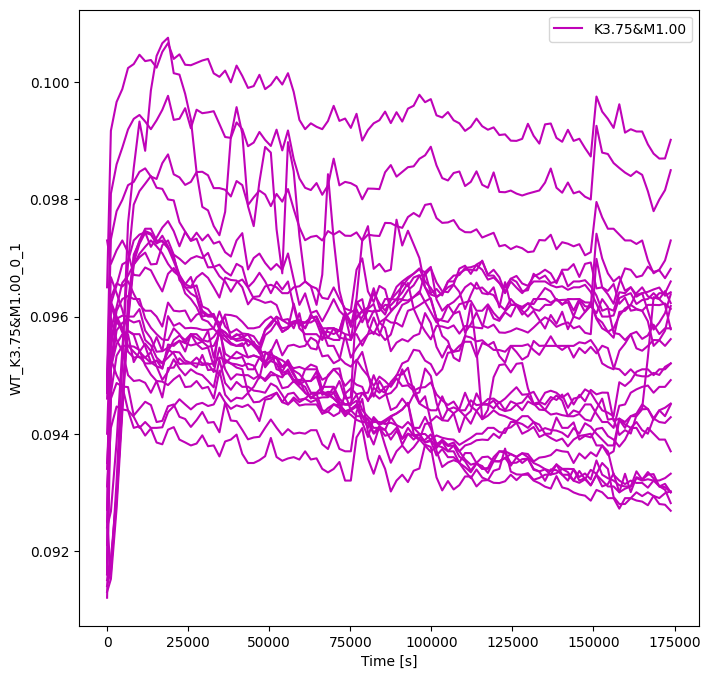

In [4]:
fig, ax = plt.subplots(1,1,figsize=[8,8])
custom_palette=sns.color_palette(cc.glasbey,len(experiments2)) 

total_data['Time [s]'] = Time
test_data['Time [s]'] = Time
train_data['Time [s]'] = Time
legend_added = set()  
batch_color_map = {}
color_index = 0
for batch in batches2:
    if batch not in batch_color_map:
        batch_color_map[batch] = custom_palette[color_index]
        color_index = (color_index + 1) % len(custom_palette)

# for column,batch in zip(test_data.columns.values[:len(batches_test)],batches_test):
#     # if batch_ not in batch_color_map:
#     #     batch_color_map[batch_] = custom_palette[color_index]
#     #     color_index = (color_index + 1) % len(custom_palette)
#     color = batch_color_map[batch]
#     if color not in legend_added:
#         sns.lineplot(data=test_data, x=test_data['Time [s]'], y=column,ax=ax,color=color,label=batch)
#         legend_added.add(color)  # Add the color to the set to indicate the legend entry is added
#     else:
#         sns.lineplot(data=test_data, x=test_data['Time [s]'], y=column,ax=ax,color=color)

for column,batch in zip(total_data.columns.values[:len(batches2)],batches2):
    # if batch_ not in batch_color_map:
    #     batch_color_map[batch_] = custom_palette[color_index]
    #     color_index = (color_index + 1) % len(custom_palette)
    color = batch_color_map[batch]
    if(batch=='K3.75&M1.00'):
        
        if color not in legend_added:
            sns.lineplot(data=total_data, x=total_data['Time [s]'], y=column,ax=ax,color=color,label=batch)
            legend_added.add(color)  # Add the color to the set to indicate the legend entry is added
        else:
            sns.lineplot(data=total_data, x=total_data['Time [s]'], y=column,ax=ax,color=color)



ax.legend()

In [5]:
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim,hidden_dim1,hidden_dim2):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim1),
            nn.Sigmoid(),
            nn.Linear(hidden_dim1, hidden_dim2),
            nn.Sigmoid()
            )
        
        self.mean_layer = nn.Linear(hidden_dim2, latent_dim)
        # self.logvar_layer =  nn.Sequential(
        #     nn.Linear(hidden_dim, latent_dim),
        #     #nn.Sigmoid()
        #     )
        self.logvar_layer=nn.Linear(hidden_dim2, latent_dim)
        
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim,hidden_dim2),
            nn.Sigmoid(),
            nn.Linear(hidden_dim2,hidden_dim1),
            nn.Sigmoid(),
            nn.Linear(hidden_dim1,input_dim),
            #nn.Sigmoid()
            )
     
    def encode(self, x):
        x = self.encoder(x)
        mean, logvar = self.mean_layer(x), self.logvar_layer(x)
        return mean, logvar

    def reparameterization(self, mean, logvar):
        epsilon = torch.randn_like(logvar)   
        z = mean + torch.exp(logvar*0.5)*epsilon   
        return z

    def decode(self, x):
        return self.decoder(x)

    def forward(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterization(mean, logvar)
        x_hat = self.decode(z)
        return x_hat, mean, logvar
    

def loss_function(x, x_hat, mean, log_var,alpha):
    reproduction_loss =nn.MSELoss()(x,x_hat)
    KLD = (- 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp()))/(x.shape[0])
    aux=reproduction_loss.detach().numpy()
    #aux1=KLD.detach().numpy()
    #print(x.shape[0],x.detach().numpy().shape,x_hat.detach().numpy().shape)
    #print(aux, "/",aux1)
    return reproduction_loss + alpha*KLD,aux

In [6]:
def train_cifar(config):
    torch.manual_seed(42)
    
    input_dim = X_train3.shape[1]  # Number of input features
    latent_dim = config['latent_dim']  
    #latent_dim = 1
    hidden_dim2 = config['hidden_dim2']
    hidden_dim1 = config['hidden_dim1']
    #hidden_dim2 = config['hidden_dim2']
    model = VAE(input_dim, latent_dim,hidden_dim1,hidden_dim2)
    #model = VAE(input_dim, latent_dim,hidden_dim2)
    alpha=5E-4
    
    # Loss function and optimizer
    optimizer = optim.Adam(model.parameters(), lr=config['lr'])     #Optimizer algorithm, lr: learning rate, config['lr']

    # Training the autoencoder
    num_epochs = 10000        #Number of 'jumps'
    #train_losses = []
    #test_losses = []
    mse_test=0
    
    for epoch in range(num_epochs):
        # Training phase
        x_hat, mean, log_var = model(X_train_tensor3)            # Forward pass
        train_loss,_ = loss_function(X_train_tensor3, x_hat, mean, log_var,alpha)

        # Backward pass and optimization, in fact this is the training of the parameters of the model
        optimizer.zero_grad()         #In this way the gradient is not cumulative
        train_loss.backward()             #The gradients(derivatives) of the parameters to optimize(points of the growth ) 
        optimizer.step()              #Actualize the optimizer(do the step of the optimizer), in the case of the Adam it multiplies the new vector by the lr

        #train_losses.append(train_loss.item())  # Append train loss

        with torch.no_grad():  # Disable gradient calculation for the test evaluation
            x_hat, mean, log_var = model(X_test_tensor3)            # Forward pass
            test_loss,mse_test = loss_function(X_test_tensor3, x_hat, mean, log_var,alpha)

        #test_losses.append(test_loss.item())  # Append test loss
    #trained_models.append(model)
    train.report({'test_loss': test_loss.item(),'mse_test':mse_test,'latent_dim':latent_dim,'hidden_dim1':hidden_dim1,'hidden_dim2':hidden_dim2}) #,'hidden_dim2':hidden_dim2,'latent_dim':latent_dim,'train_loss': train_loss.item()
    


In [ ]:
#n=816(s2) 10000epoch 
def main(num_samples=64, max_num_epochs=1):   

    config = {
        'lr':tune.loguniform(5e-6, 1e-2),
        'hidden_dim1': tune.sample_from(lambda _: random.choice([24, 32, 40, 48])),
        'hidden_dim2': tune.sample_from(lambda _: random.choice([8, 12, 16, 20])),
        'latent_dim': tune.sample_from(lambda _: random.choice([1, 2, 4, 5, 6]))
    }
    # Set environment variable to suppress the warning
    os.environ["TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S"] = "0.1"  # Example value

    scheduler = ASHAScheduler(
        max_t=max_num_epochs,
        grace_period=1,
        reduction_factor=2,
    )
    tuner = tune.Tuner(
        train_cifar,
        tune_config=tune.TuneConfig(
            metric="test_loss",
            mode="min",
            scheduler=scheduler,
            num_samples=num_samples,
        ),
        param_space=config,
    )
    results = tuner.fit()
    
    best_result = results.get_best_result("test_loss", "min")

    print("Best trial config: {}".format(best_result.config))
    print("Best trial final test loss: {}".format(best_result.metrics['test_loss']))
    #print("Best trial final mse loss: {}".format(best_result.metrics['mse']))
    
    # Collect results into a DataFrame
    results_list = []
    for trial in results:
        result_data = trial.config.copy()
        result_data.update(trial.metrics)
        results_list.append(result_data)
    
    results_df = pd.DataFrame(results_list)

    # Save the DataFrame to a CSV file
    results_df.to_csv('tuning_results.csv', index=False)

    print("Results saved to tuning_results.csv")


main()

2024-05-23 16:38:35,467	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 1.338 s, which may be a performance bottleneck.
2024-05-23 16:38:35,467	WARNING util.py:201 -- The `process_trial_result` operation took 1.338 s, which may be a performance bottleneck.
2024-05-23 16:38:35,477	WARNING util.py:201 -- Processing trial results took 1.347 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-05-23 16:38:35,478	WARNING util.py:201 -- The `process_trial_result` operation took 1.349 s, which may be a performance bottleneck.
2024-05-23 16:47:40,379	INFO tune.py:1007 -- Wrote the latest version of all result files and experiment state to 'C:/Users/omar.blanco/ray_results/train_cifar_2024-05-23_16-19-01' in 0.2328s.
2024-05-23 16:47:40,450	INFO tune.py:1039 -- Total run time: 1713.09 seconds (1712.65 seconds for the tuning loop).


Best trial config: {'lr': 0.0035606676529242026, 'hidden_dim1': 48, 'hidden_dim2': 16, 'latent_dim': 2}
Best trial final test loss: 0.0030195959843695164
Results saved to tuning_results.csv


In [12]:
#n=816(s2) 10000epoch 
def main(num_samples=64, max_num_epochs=1):   

    config = {
        'lr':tune.loguniform(5e-6, 1e-2),
        'hidden_dim1': tune.sample_from(lambda _: random.choice([24, 32, 40, 48])),
        'hidden_dim2': tune.sample_from(lambda _: random.choice([8, 12, 16, 20])),
        'latent_dim': tune.sample_from(lambda _: random.choice([1, 2, 4, 5, 6]))
    }
    # Set environment variable to suppress the warning
    os.environ["TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S"] = "0.1"  # Example value

    scheduler = ASHAScheduler(
        max_t=max_num_epochs,
        grace_period=1,
        reduction_factor=2,
    )
    tuner = tune.Tuner(
        train_cifar,
        tune_config=tune.TuneConfig(
            metric="test_loss",
            mode="min",
            scheduler=scheduler,
            num_samples=num_samples,
        ),
        param_space=config,
    )
    results = tuner.fit()
    
    best_result = results.get_best_result("test_loss", "min")

    print("Best trial config: {}".format(best_result.config))
    print("Best trial final test loss: {}".format(best_result.metrics['test_loss']))
    #print("Best trial final mse loss: {}".format(best_result.metrics['mse']))
    
    # Collect results into a DataFrame
    results_list = []
    for trial in results:
        result_data = trial.config.copy()
        result_data.update(trial.metrics)
        results_list.append(result_data)
    
    results_df = pd.DataFrame(results_list)

    # Save the DataFrame to a CSV file
    results_df.to_csv('tuning_results2.csv', index=False)

    print("Results saved to tuning_results2.csv")


main()

2024-05-23 18:14:45,350	INFO tune.py:1007 -- Wrote the latest version of all result files and experiment state to 'C:/Users/omar.blanco/ray_results/train_cifar_2024-05-23_17-44-49' in 0.1444s.
2024-05-23 18:14:45,372	INFO tune.py:1039 -- Total run time: 1789.81 seconds (1789.48 seconds for the tuning loop).


Best trial config: {'lr': 0.00845989001358385, 'hidden_dim1': 32, 'hidden_dim2': 12, 'latent_dim': 6}
Best trial final test loss: 0.0030214423313736916
Results saved to tuning_results2.csv


In [12]:
torch.manual_seed(42)
trained_models = []

input_dim = X_train3.shape[1]  # Number of input features
latent_dim = 2  # Desired number of output dimensions
hidden_dim2 = 16
hidden_dim1 = 48
model = VAE(input_dim, latent_dim,hidden_dim1,hidden_dim2)
alpha=5E-5  #or maybe 1E-5 is better
str_alpha="{:.0E}".format(alpha)


# Loss function and optimizer
#criterion = nn.MSELoss()            #Mean Square Error Loss
optimizer = optim.Adam(model.parameters(), lr=1E-3)     #Optimizer algorithm, lr: learning rate

# Training the autoencoder
num_epochs = 10000          #Number of 'jumps'
train_losses = []
test_losses = []
mse_test=0
for epoch in range(num_epochs):
   # Training phase
   x_hat, mean, log_var = model(X_train_tensor3)            # Forward pass
   train_loss,_ = loss_function(X_train_tensor3, x_hat, mean, log_var,alpha)

   # Backward pass and optimization, in fact this is the training of the parameters of the model
   optimizer.zero_grad()         #In this way the gradient is not cumulative
   train_loss.backward()             #The gradients(derivatives) of the parameters to optimize(points of the growth ) 
   optimizer.step()              #Actualize the optimizer(do the step of the optimizer), in the case of the Adam it multiplies the new vector by the lr

   train_losses.append(train_loss.item())  # Append train loss
   
   with torch.no_grad():  # Disable gradient calculation for the test evaluation
      x_hat, mean, log_var = model(X_test_tensor3)            # Forward pass
      test_loss,mse_test = loss_function(X_test_tensor3, x_hat, mean, log_var,alpha)
   print(mse_test,test_loss.detach().numpy())
   test_losses.append(test_loss.item())  # Append test loss
trained_models.append(model)
#torch.save(model.state_dict(), 'saved_models/VAE_n1000_alpha{str_alpha[0]}E{str_alpha[4]}lr5E4_v3.pth')
print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss.item():.4f}, Test Loss: {test_loss.item():.4f}')

0.52319646 0.52319676
0.49628338 0.49628377
0.46966645 0.46966702
0.44511527 0.44511607
0.42169642 0.4216975
0.3997009 0.3997023
0.37916788 0.37916964
0.35994416 0.35994634
0.34173402 0.34173664
0.3246258 0.3246289
0.30870032 0.30870396
0.29387432 0.2938785
0.2802254 0.28023016
0.26731932 0.2673247
0.25524497 0.25525093
0.24448138 0.24448799
0.23422027 0.23422752
0.22474898 0.22475691
0.2163479 0.2163565
0.20859331 0.20860259
0.20134175 0.20135172
0.19484843 0.19485909
0.18872616 0.1887375
0.18360251 0.18361454
0.17843686 0.17844956
0.17415752 0.1741709
0.17033923 0.17035326
0.16694257 0.16695726
0.1636098 0.16362512
0.16084048 0.16085643
0.15849788 0.15851443
0.15630302 0.15632014
0.15441664 0.15443431
0.15254414 0.15256235
0.15118349 0.15120222
0.15004238 0.1500616
0.14891517 0.14893487
0.1478306 0.14785075
0.14703889 0.14705946
0.14647715 0.1464981
0.14585522 0.14587656
0.14522332 0.145245
0.14494695 0.14496894
0.14455709 0.14457938
0.14427295 0.14429553
0.14377077 0.14379361
0.1438

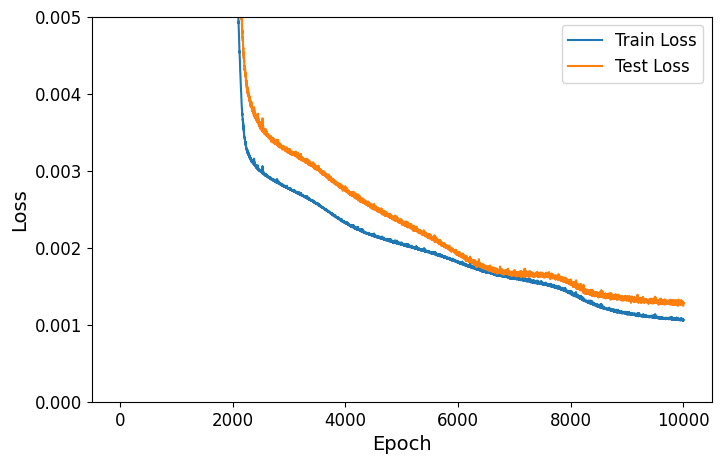

In [13]:
fig, ax = plt.subplots(1,1,figsize=[8,5])
#plt.title('Train and Test Loss over Epochs')
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
epochs = range(1, num_epochs + 1)

sns.lineplot(x=epochs, y=train_losses, label='Train Loss',ax=ax)
sns.lineplot(x=epochs, y=test_losses, label='Test Loss',ax=ax)
ax.set_ylim(0, 0.005)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.legend(fontsize=12)

110 (100, 111)
1 29 ['LB']
1 14 ['LB', 'K1.25']
1 22 ['LB', 'K1.25', 'K2.50']
1 6 ['LB', 'K1.25', 'K2.50', 'K3.75']
1 4 ['LB', 'K1.25', 'K2.50', 'K3.75', 'M0.25']
1 4 ['LB', 'K1.25', 'K2.50', 'K3.75', 'M0.25', 'M0.50']
1 4 ['LB', 'K1.25', 'K2.50', 'K3.75', 'M0.25', 'M0.50', 'M1.00']
1 3 ['LB', 'K1.25', 'K2.50', 'K3.75', 'M0.25', 'M0.50', 'M1.00', 'K1.25&M0.25']
1 3 ['LB', 'K1.25', 'K2.50', 'K3.75', 'M0.25', 'M0.50', 'M1.00', 'K1.25&M0.25', 'K1.25&M0.50']
1 3 ['LB', 'K1.25', 'K2.50', 'K3.75', 'M0.25', 'M0.50', 'M1.00', 'K1.25&M0.25', 'K1.25&M0.50', 'K1.25&M1.00']
1 3 ['LB', 'K1.25', 'K2.50', 'K3.75', 'M0.25', 'M0.50', 'M1.00', 'K1.25&M0.25', 'K1.25&M0.50', 'K1.25&M1.00', 'K2.50&M0.25']
1 3 ['LB', 'K1.25', 'K2.50', 'K3.75', 'M0.25', 'M0.50', 'M1.00', 'K1.25&M0.25', 'K1.25&M0.50', 'K1.25&M1.00', 'K2.50&M0.25', 'K2.50&M0.50']
1 3 ['LB', 'K1.25', 'K2.50', 'K3.75', 'M0.25', 'M0.50', 'M1.00', 'K1.25&M0.25', 'K1.25&M0.50', 'K1.25&M1.00', 'K2.50&M0.25', 'K2.50&M0.50', 'K2.50&M1.00']
1 3 ['LB', 

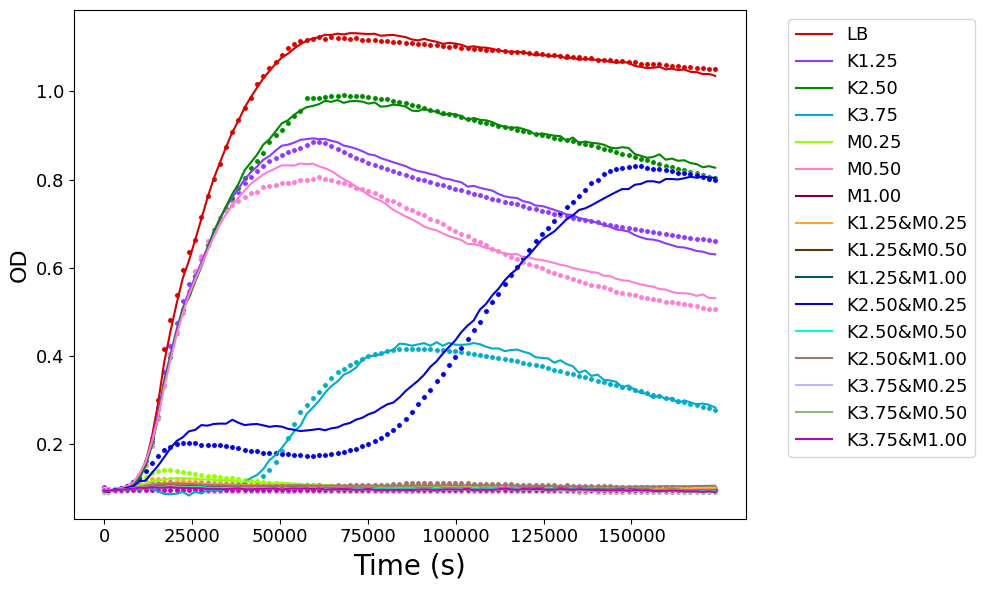

In [19]:
#Plotting the decoded vectors
fig, ax = plt.subplots(1,1,figsize=[10,6])
custom_palette=sns.color_palette(cc.glasbey,len(experiments2))

model=trained_models[0]
# # input_dim = X_train3.shape[1]  # Number of input features
# # latent_dim = 1  # Desired number of output dimensions
# # hidden_dim=8
# # model = VAE(input_dim, latent_dim,hidden_dim) # we do not specify ``weights``, i.e. create untrained model
# # alpha=5E-5
# # str_alpha="{:.0E}".format(alpha)
# # model.load_state_dict(torch.load('saved_models/VAE_n1000_alpha{str_alpha[0]}E{str_alpha[4]}lr5E4_v3.pth'))

# test_mean,test_logvar = model.encode(X_test_tensor3)
# train_mean,train_logvar = model.encode(X_train_tensor3)
# test_mean = test_mean.detach().numpy()
# test_logvar = test_logvar.detach().numpy()
# train_mean = train_mean.detach().numpy()
# train_logvar = train_logvar.detach().numpy()

# decoded_test = model.decode(torch.FloatTensor(test_mean)).detach().numpy()
# decoded_test_df=pd.DataFrame(decoded_test).T
# decoded_train = model.decode(torch.FloatTensor(train_mean)).detach().numpy()
# decoded_train_df=pd.DataFrame(decoded_train).T

# decoded_test_df['Time [s]'] = Time
# decoded_train_df['Time [s]']  = Time
# test_data['Time [s]'] = Time
# train_data['Time [s]'] = Time

# #Creating a dictionary in order to map unique batches to colors
# batch_color_map = {}
# color_index = 0
# legend_added = set() 
# for batch in batches_test:
#     if batch not in batch_color_map:
#         batch_color_map[batch] = custom_palette[color_index]
#         color_index = (color_index + 1) % len(custom_palette)

# for column,column2, batch in zip(decoded_test_df.columns.values[:len(batches_test)],test_data.columns.values[:len(batches_test)], batches_test):
#     color = batch_color_map[batch]
#     if color not in legend_added:
#         sns.lineplot(data=decoded_test_df, x='Time [s]', y=column, ax=ax, color=color, label=batch)
#         sns.scatterplot(data=test_data, x='Time [s]', y=column2, ax=ax, color=color,s=15)
#         legend_added.add(color)  # Add the color to the set to indicate the legend entry is added
#     else:
#         sns.lineplot(data=decoded_test_df, x='Time [s]', y=column, ax=ax, color=color)
#         sns.scatterplot(data=test_data, x='Time [s]', y=column2, ax=ax, color=color,s=15)
print(len(batches_test),test_data.shape)        
columns2=test_data.columns[:len(batches_test)]
num_list2 = list(range(len(batches_test)))
test_data2=pd.DataFrame()
batches_test2=[]
np.random.seed(4)

#take only one curve from each experiment to not overcharge the plot
for experiment in experiments2:
    columns_to_select=[]
    for batch,i in zip(batches_test,num_list2):
        if batch==experiment:
            columns_to_select.append(columns2[i])    
    test_columns = np.random.choice(columns_to_select,1,replace=False)
    batches_test2.append(experiment)
    test_columns_data = total_data[test_columns]
    print(len(test_columns),len(columns_to_select),batches_test2)
    test_data2 = pd.concat([test_data2, test_columns_data], axis=1)

#transform the subset test in a tensor, encode it and decode it
test_data2_T=test_data2.T
X_test4=test_data2_T.values
X_test_tensor4 = torch.FloatTensor(X_test4)

test_mean,test_logvar = model.encode(X_test_tensor4)
test_mean = test_mean.detach().numpy()
test_logvar = test_logvar.detach().numpy()

decoded_test2 = model.decode(torch.FloatTensor(test_mean)).detach().numpy()
decoded_test2_df=pd.DataFrame(decoded_test2).T

decoded_test2_df['Time [s]'] = Time
test_data2['Time [s]'] = Time
 

for column,column2,color,batch in zip(decoded_test2_df.columns.values[:len(batches_test2)],test_data2.columns.values[:len(batches_test2)], custom_palette,batches_test2):
    sns.lineplot(data=decoded_test2_df, x='Time [s]', y=column, ax=ax, color=color, label=batch)
    sns.scatterplot(data=test_data2, x='Time [s]', y=column2, ax=ax, color=color,s=15)

plt.xlabel('Time (s)', fontsize=16)
plt.ylabel('OD', fontsize=16)
ax.set_xticks(range(0, 175000, 25000))
ax.tick_params(axis='both', which='major', labelsize=13)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', prop={'size': 13})
plt.tight_layout()  # Adjust layout to make room for the legend
plt.show()



110 16
[-1.9407264 -1.8908018] [1.5412592 1.8812948]
[-1.9167122 -1.875679 ] [1.4981915 1.7653728]
[0.01906062 0.01369317] [0.08326394 0.11592212]
[[ 1.42645754 -1.07569133]
 [-0.0352716   1.7917998 ]
 [ 1.44614651 -1.86730066]
 [ 0.54825258 -0.93652787]
 [ 0.4887553  -0.25072611]]


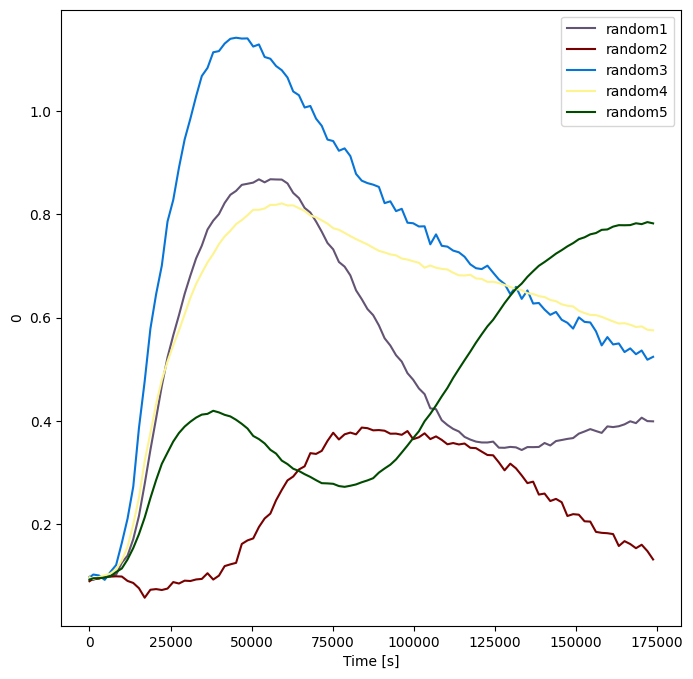

In [10]:
#Create 5 random vectors(of encoded dim, the 5) and see how are its decoded curves
np.random.seed(4)
#random_arrays = []
random_batches = [f'random{i+1}' for i in range(5)]       #5:number of random vectors
all_batches = np.concatenate((batches_test, batches_train,random_batches))
dataset_batches=np.concatenate((batches_test, batches_train))
custom_palette=sns.color_palette(cc.glasbey,len(experiments2)+len(random_batches))  #+ ['#353839']
print(len(batches_test),len(experiments2))
fig, ax = plt.subplots(1,1,figsize=[8,8])

random_array = np.zeros((5, latent_dim))   # Initialize random_array
test_mean,test_logvar = model.encode(X_test_tensor3)
train_mean,train_logvar = model.encode(X_train_tensor3)
test_mean = test_mean.detach().numpy()
test_logvar = test_logvar.detach().numpy()
train_mean = train_mean.detach().numpy()
train_logvar = train_logvar.detach().numpy()

total_mean = np.concatenate((test_mean, train_mean), axis=0)
total_logvar = np.concatenate((test_logvar, train_logvar), axis=0)
aux=np.concatenate((total_mean+np.exp(total_logvar*0.5), total_mean-np.exp(total_logvar*0.5)), axis=0)      #1 sigma range
#aux=np.concatenate((total_mean, total_mean+np.exp(total_logvar)), axis=0)
#print(total_mean,total_logvar*0.5)
#print(aux)

# Calculate min and max values along each column of encoded_data
min_values = aux.min(axis=0)
max_values = aux.max(axis=0)
print(min_values,max_values)
print(total_mean.min(axis=0),total_mean.max(axis=0))
print(np.exp(total_logvar*0.5).min(axis=0),np.exp(total_logvar*0.5).max(axis=0))
for i in range(latent_dim):  # Iterate over each column
    random_array[:, i] = np.random.uniform(low=min_values[i], high=max_values[i], size=5)
#random_arrays.append(random_array)
print(random_array)

#Decoding the data using the trained autoencoder 
decoded_random = pd.DataFrame(model.decoder(torch.FloatTensor(random_array)).detach().numpy())

#Transpose it in order to plot 
decoded_random=decoded_random.T
decoded_random['Time [s]'] = Time

#Plot the decoded vectors
for column, color,batch in zip(decoded_random.columns.values[:5], custom_palette[len(experiments2):],random_batches):
    sns.lineplot(data=decoded_random, x='Time [s]', y=column, ax=ax, color=color, label=batch)
    #sns.scatterplot(data=test_data, x=test_data['Time [s]'].values, y=test_data.iloc[:,column], ax=ax, color=color, label=batch,s=15)

ax.legend()


            0         1 categories marker_style
0   -0.033171 -1.366884         LB            o
1   -0.351717 -1.531171         LB            o
2   -0.910915 -1.382257         LB            o
3   -0.733872 -1.457734         LB            o
4   -0.036544 -1.391938         LB            o
..        ...       ...        ...          ...
816  1.426458 -1.075691    random1            ^
817 -0.035272  1.791800    random2            ^
818  1.446147 -1.867301    random3            ^
819  0.548253 -0.936528    random4            ^
820  0.488755 -0.250726    random5            ^

[821 rows x 4 columns]


C:\Users\Usuario\AppData\Local\Temp\ipykernel_13808\3168423245.py:38: UserWarning: The palette list has more values (21) than needed (16), which may not be intended.
  sns.scatterplot(data=data_subset, x=x_col, y=y_col, hue='categories', palette=custom_palette)


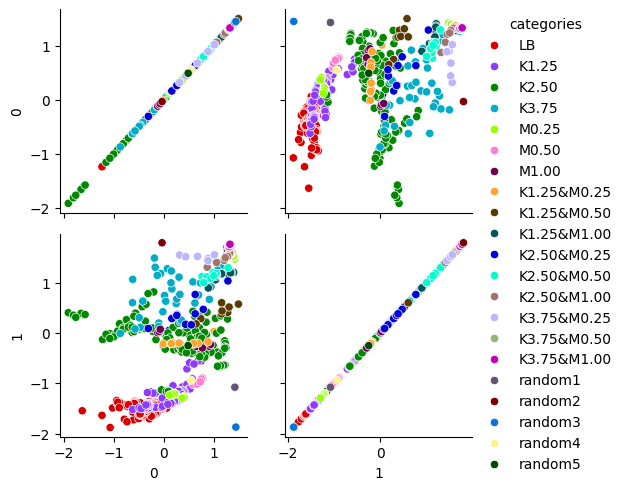

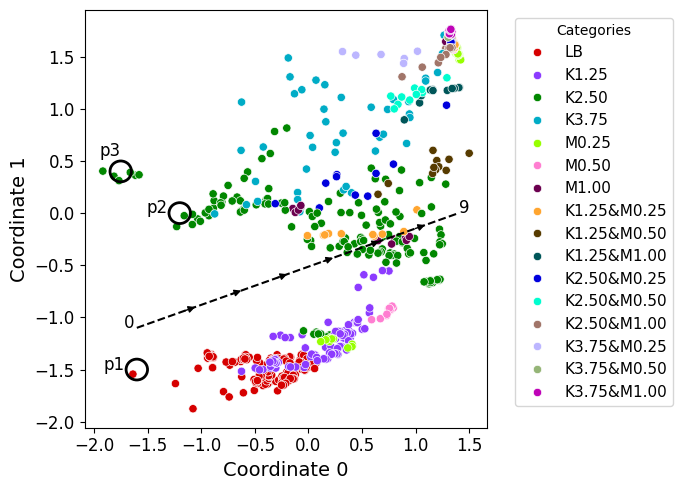

In [63]:
# Encoding the data using the trained autoencoder
test_mean,test_logvar = model.encode(X_test_tensor3)
train_mean,train_logvar = model.encode(X_train_tensor3)
test_mean = test_mean.detach().numpy()
test_logvar = test_logvar.detach().numpy()
train_mean = train_mean.detach().numpy()
train_logvar = train_logvar.detach().numpy()

total_mean_df = pd.DataFrame(np.concatenate((test_mean, train_mean), axis=0))
random_df = pd.DataFrame(random_array)
whole_df = pd.concat([total_mean_df,random_df], ignore_index=True)

whole_style = ['o'] * (len(batches_test) + len(batches_train))
random_style = ['^'] * len(random_batches)
marker_styles = whole_style + random_style
whole_df['categories'] = all_batches
total_mean_df['categories']=dataset_batches
whole_df['marker_style'] = marker_styles
print(whole_df)

custom_palette=sns.color_palette(cc.glasbey,len(experiments2)+5) #5 ecause 5 random curves
g = sns.PairGrid(whole_df,hue='categories',palette=custom_palette)
# g = sns.PairGrid(whole_df,hue='categories',palette=custom_palette,hue_kws={"marker":'marker_style'})
g.map(sns.scatterplot)
g.add_legend()

x_col = g.x_vars[0]  # The x variable for the subplot at (1, 0)
y_col = g.y_vars[1]  # The y variable for the subplot at (1, 0)
data_subset = total_mean_df[[x_col, y_col, 'categories']]

# Define points
p1 = (-1.6, -1.5)
p2 = (-1.2, 0)
p3 = (-1.75, 0.4)

# Plot the extracted data in a new figure
fig, ax = plt.subplots(1,1,figsize=[7,5])
sns.scatterplot(data=data_subset, x=x_col, y=y_col, hue='categories', palette=custom_palette)

# Add the dashed line
x_start, x_end = -1.6, 1.40
y_start, y_end = -1.1, 0.0
plt.plot([x_start, x_end], [y_start, y_end], linestyle='--', color='black')

# Function to add multiple arrows along a line
def add_arrows(x_start, x_end, y_start, y_end, num_arrows=5, arrow_length=0.1):
    arrowprops = dict(facecolor='black', edgecolor='black', arrowstyle='-|>', lw=1)
    for i in np.linspace(0, 1, num_arrows, endpoint=False)[1:]:
        x = x_start + i * (x_end - x_start)
        y = y_start + i * (y_end - y_start)
        dx = (x_end - x_start) * arrow_length / np.hypot(x_end - x_start, y_end - y_start)
        dy = (y_end - y_start) * arrow_length / np.hypot(x_end - x_start, y_end - y_start)
        ax.annotate('', xy=(x + dx, y + dy), xytext=(x, y), arrowprops=arrowprops)

# Add arrows along the dashed line
add_arrows(x_start, x_end, y_start, y_end, num_arrows=7, arrow_length=0.15)
# Add circles at the specified points
circle1 = plt.Circle(p1, 0.1, color='black', fill=False, linewidth=2, zorder=5)  # Adjust radius as needed
circle2 = plt.Circle(p2, 0.1, color='black', fill=False, linewidth=2, zorder=5)
circle3 = plt.Circle(p3, 0.1, color='black', fill=False, linewidth=2, zorder=5)
ax.add_artist(circle1)
ax.add_artist(circle2)
ax.add_artist(circle3)
plt.text(p1[0]-0.11, p1[1], 'p1', fontsize=12, color='black', ha='right')
plt.text(p2[0]-0.11, p2[1], 'p2', fontsize=12, color='black', ha='right')
plt.text(p3[0], p3[1]+0.15, 'p3', fontsize=12, color='black', ha='right')
plt.text(x_start-0.02, y_start, '0', fontsize=12, color='black', ha='right')
plt.text(x_end+0.1, y_end, '9', fontsize=12, color='black', ha='right')
# Customize the plot

plt.xlabel('Coordinate 0', fontsize=14)
plt.ylabel('Coordinate 1', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)
# Place the legend outside the plot
plt.legend(title='Categories', bbox_to_anchor=(1.05, 1), loc='upper left',fontsize=11)
plt.tight_layout()  # Adjust layout to make room for the legend
plt.show()



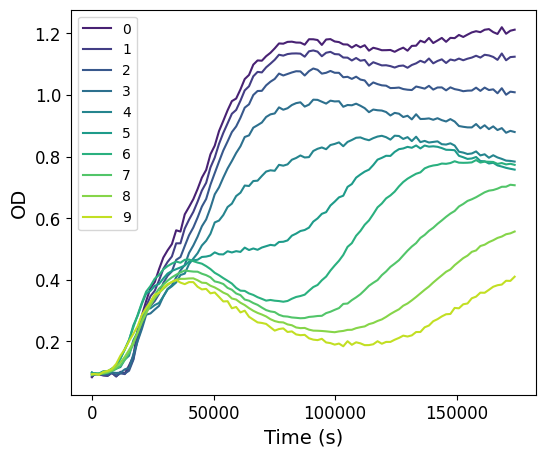

In [64]:
#Now lets see how is the form of the whole latent space to check the completeness and continuity
min_value=[-1.6, -1.1]
max_value=[1.40, 0.0]
whole_latent_space=np.linspace(min_value,max_value,num=10)     #curves from the latent space

#Decoding the data using the trained autoencoder 
whole_latent_space_df= pd.DataFrame(model.decoder(torch.FloatTensor(whole_latent_space)).detach().numpy())

#Transpose it in order to plot 
whole_latent_space_df=whole_latent_space_df.T
whole_latent_space_df['Time [s]'] = Time

fig, ax = plt.subplots(1,1,figsize=[6,5])

#Plot the decoded vectors
custom_palette2=sns.color_palette('viridis',10)
for column, color in zip(whole_latent_space_df.columns.values[:10], custom_palette2[:10]):
    sns.lineplot(data=whole_latent_space_df, x='Time [s]', y=column, ax=ax, color=color, label=whole_latent_space_df.columns.values[column])

plt.xlabel('Time (s)', fontsize=14)
plt.ylabel('OD', fontsize=14)
ax.set_xticks(range(0, 175000, 50000))
ax.tick_params(axis='both', which='major', labelsize=12)
ax.legend()

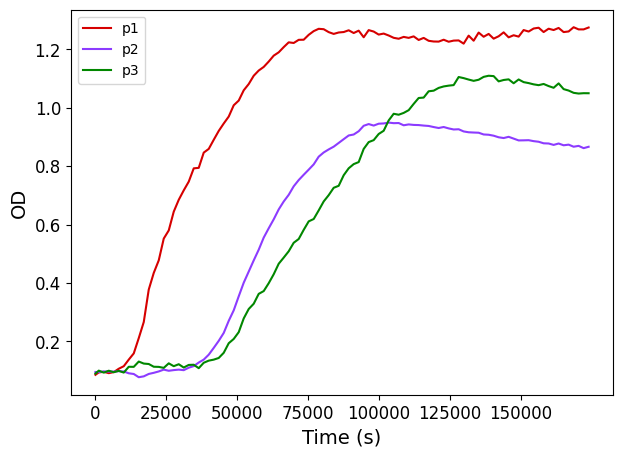

In [65]:
#Now lets see how is the form of the whole latent space to check the completeness and continuity
p1=[-1.6,-1.5]    #'LB'
p2=[-1.2, 0]    #'K2.50' 
p3=[-1.75, 0.4]     #'K2.50'  
specific_points=[p1,p2,p3]     #curves from the latent space

#Decoding the data using the trained autoencoder 
decoded_points= pd.DataFrame(model.decoder(torch.FloatTensor(specific_points)).detach().numpy())

#Transpose it in order to plot 
decoded_points=decoded_points.T
new_column_names=['p1','p2','p3']
decoded_points.columns=new_column_names
decoded_points['Time [s]'] = Time

fig, ax = plt.subplots(1,1,figsize=[7,5])

#Plot the decoded vectors
palette=sns.color_palette(cc.glasbey,len(experiments2))
# p1_drug='LB'
# p2_drug='K2.50'
# index_drug1=experiments2.index(p1_drug)
# index_drug2=experiments2.index(p2_drug)
# palette=[palette[index_drug1], palette[index_drug2], palette[index_drug2]]
for column, color in zip(decoded_points.columns.values[:len(specific_points)], palette):
    sns.lineplot(data=decoded_points, x='Time [s]', y=column, ax=ax, color=color, label=column)

plt.xlabel('Time (s)', fontsize=14)
plt.ylabel('OD', fontsize=14)
ax.set_xticks(range(0, 175000, 25000))
ax.tick_params(axis='both', which='major', labelsize=12)
ax.legend()

<Axes: xlabel='1', ylabel='Density'>

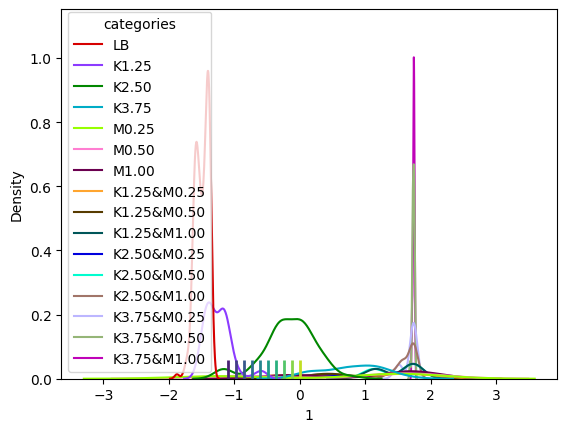

In [14]:
df1=pd.DataFrame(whole_latent_space)
df1['categories1']=whole_latent_space_df.columns.values[:len(whole_latent_space)]

custom_palette1=sns.color_palette(cc.glasbey,len(experiments2))
custom_palette2=sns.color_palette('viridis',10)

x=1
sns.kdeplot(data=total_mean_df, x=x,hue='categories',palette=custom_palette1)
sns.rugplot(data=df1,x=x,hue='categories1',palette=custom_palette2,height=0.05, linewidth=2,legend=False)


10
(816, 3)


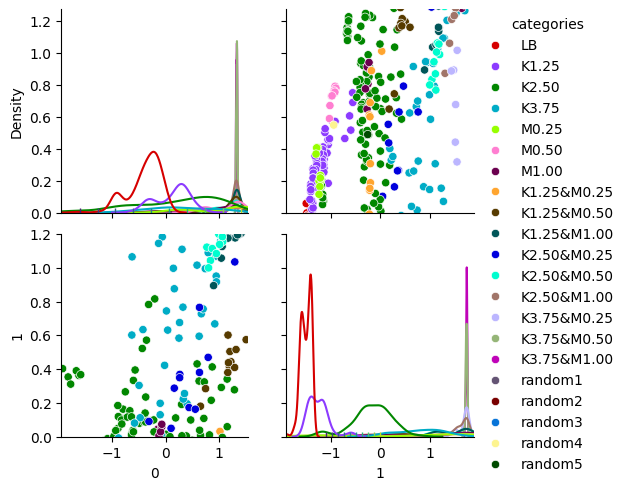

In [15]:
from scipy.stats import gaussian_kde

print(len(whole_latent_space))
df1=pd.DataFrame(whole_latent_space)
df1['categories1']=whole_latent_space_df.columns.values[:len(whole_latent_space)]

custom_palette2=sns.color_palette('viridis',10)
print(total_mean_df.shape)
# sns.kdeplot(data=total_mean_df, x=1,hue='categories',palette=custom_palette)
# sns.rugplot(data=df1,x=1,palette=custom_palette2)

def diag_plot(x):
    sns.kdeplot(data=total_mean_df,x=x,hue='categories',palette=custom_palette)
    sns.rugplot(data=df1,x=x,palette=custom_palette2)

#diag_plot(0)
custom_palette=sns.color_palette(cc.glasbey,len(experiments2)+5)
custom_palette1=sns.color_palette(cc.glasbey,len(experiments2))
custom_palette2=sns.color_palette('viridis',10)
g = sns.PairGrid(data=whole_df, hue='categories', palette=custom_palette)
g.map(sns.scatterplot)

#save original axes
original_xlim = g.axes[0, 1].get_xlim()
original_ylim = g.axes[0, 1].get_ylim()
original_xlabel = g.axes[0, 1].get_xlabel()
original_ylabel = g.axes[0, 1].get_ylabel()

g.axes[0, 0].clear()  # Clear the existing plot
kde=sns.kdeplot(data=total_mean_df, x=0, hue='categories', palette=custom_palette1, ax=g.axes[0, 0],legend=False)
sns.rugplot(data=df1, x=0,hue='categories1', palette=custom_palette2, ax=g.axes[0, 0],legend=False)
g.axes[0, 0].set_xlim(min_values[0], max_values[0])  # Set custom x-axis limits
g.axes[0, 0].set_ylim(0, max(kde.get_lines()[0].get_ydata())*1.2)  # Set custom y-axis limits
g.axes[0, 0].set_xlabel("0")  # Set custom x-axis label
#g.axes[0, 0].set_ylabel("Custom Y Label (0,0)")  # Set custom y-axis label

# (1,1) subplot with a rugplot
g.axes[1, 1].clear()  # Clear the existing plot
kde=sns.kdeplot(data=total_mean_df, x=1, hue='categories', palette=custom_palette1, ax=g.axes[1, 1],legend=False)
sns.rugplot(data=df1, x=1,hue='categories1', palette=custom_palette2, ax=g.axes[1, 1],legend=False)
g.axes[1, 1].set_xlim(min_values[1], max_values[1])
g.axes[1, 1].set_ylim(0, max(kde.get_lines()[0].get_ydata())*1.2)  
g.axes[1, 1].set_xlabel("1")  
#g.axes[1, 1].set_ylabel("Density")  

# # Restore the original axis limits and labels for the scatter plots
# g.axes[1, 0].set_xlim(original_xlim)
# g.axes[1, 0].set_ylim(original_ylim)
# g.axes[1, 0].set_xlabel(original_xlabel)
# g.axes[1, 0].set_ylabel(original_ylabel)

# g.axes[0, 1].set_xlim(original_xlim)
# g.axes[0, 1].set_ylim(original_ylim)
# g.axes[0, 1].set_xlabel(original_xlabel)
# g.axes[0, 1].set_ylabel(original_ylabel)

g.add_legend()

In [16]:
from scipy.stats import gaussian_kde
kde = gaussian_kde(total_mean_df[1])

# Evaluate the KDE on a grid of values
x_vals = np.linspace(min(total_mean_df[1]), max(total_mean_df[1]), 100000)  # You can adjust the number of points
y_vals = kde(x_vals)
print(np.max(y_vals)*1.2)

0.4884641622598888


<script>
const css = `
body {
    background-color: #1E1E1E; /* Dark Modern theme background color */
    color: #D4D4D4; /* Light gray text color */
    font-family: Arial, sans-serif; /* Readable font */
}

.json-output {
    background-color: #252526; /* Slightly lighter than body background */
    color: #D4D4D4; /* Light gray text color */
    font-family: 'Courier New', Courier, monospace; /* Monospaced font for JSON */
    padding: 10px;
    border-radius: 5px;
    border: 1px solid #3C3C3C; /* Border to distinguish JSON block */
}

pre.json-output {
    overflow: auto;
    white-space: pre-wrap; /* Wrap long lines */
    word-wrap: break-word; /* Break long words */
}
`;

const style = document.createElement('style');
style.innerHTML = css;
document.head.appendChild(style);
</script>
